<a href="https://colab.research.google.com/github/akseljoonas/rec-system-MLFortnight/blob/main/main_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Game Recommendation!!


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install transformers torch kaggle

In [46]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!echo '{"username":"elaklunder","key":"0ef13f8c58212064b76201f6a0deb398"}' > ~/.kaggle/kaggle.json
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download dataset
!kaggle competitions download -c fcg-2023-game-recommendation

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
fcg-2023-game-recommendation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [47]:
# create data folder
!mkdir data

# unzip dataset
!unzip -q fcg-2023-game-recommendation.zip -d data/

mkdir: cannot create directory ‘data’: File exists
replace data/game_metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [49]:
import pandas as pd                 # pandas is a dataframe library
import numpy as np                  # numpy provides N-dim object support
import matplotlib.pyplot as plt     # matplotlib.pyplot plots data
import seaborn as sns               # seaborn is the big brother of matplotlib
import os                           # os handles directory/workspace changes
from tqdm import tqdm_notebook      # tqdm_notebook is the progress bar library

from sklearn.model_selection import train_test_split # to split out training and testing data
from sklearn.preprocessing import LabelEncoder       # to convert labels into numbers
from sklearn.metrics import mean_absolute_error      # for mean absolute error
from sklearn.preprocessing import MinMaxScaler       # for using a normalization scaler
from sklearn.metrics import fbeta_score              # for scoring the models

import tensorflow as tf             # tensorflow is the machine learning library we will be using

pd.set_option('display.max_columns', 100) # Display up to 100 columns of a dataframe
pd.set_option('display.max_rows', 100)    # Display up to 100 rows of a dataframe

## Data Analysis and Preprocessing

In [129]:
game_data = pd.read_csv("./data/game_metadata.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [ ]:
game_data.head()

,name,appid,required_age,is_free,controller_support,detailed_description,about_the_game,short_description,supported_languages,reviews,pc_requirements,mac_requirements,linux_requirements,developers,publishers,price_overview,platforms,categories,genres,recommendations,achievements,release_date,content_descriptors,metacritic,ext_user_account_notice,drm_notice
0,Nova Drift,858210,0,False,full,<h1>JOIN THE DISCORD COMMUNITY</h1><p><a href=...,"<h2 class=""bb_tag""><strong>- SURVIVE - EVOLVE ...",Nova Drift distills the mechanical depth and s...,"English, French, Russian, Simplified Chinese, ...",“Its integration of rogue-lite unlocks and a r...,{'minimum': '<strong>Minimum:</strong><br><ul ...,{'minimum': '<strong>Minimum:</strong><br><ul ...,[],['Chimeric'],['Pixeljam'],"{'currency': 'EUR', 'initial': 1699, 'final': ...","{'windows': True, 'mac': True, 'linux': False}","[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '1', 'description': 'Action'}, {'id': ...",{'total': 9354},"{'total': 40, 'highlighted': [{'name': 'Planet...","{'coming_soon': False, 'date': '27 Mar, 2019'}","{'ids': [], 'notes': None}",NaN,NaN,NaN
1,Sid Meier's Civilization® V,8930,0,False,NaN,The Flagship Turn-Based Strategy Game Returns<...,The Flagship Turn-Based Strategy Game Returns<...,"Create, discover, and download new player-crea...","English<strong>*</strong>, French<strong>*</st...",NaN,{'minimum': '<strong>Minimum:</strong><br>\t\t...,{'minimum': '<strong>Minimum:</strong><br>\t\t...,"{'minimum': ""<strong>Operating System:</strong...","['Firaxis Games', 'Aspyr (Mac)', 'Aspyr (Linux)']","['2K', 'Aspyr (Mac)', 'Aspyr (Linux)']","{'currency': 'EUR', 'initial': 2999, 'final': ...","{'windows': True, 'mac': True, 'linux': True}","[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '2', 'description': 'Strategy'}]",{'total': 118286},"{'total': 286, 'highlighted': [{'name': 'First...","{'coming_soon': False, 'date': '23 Sep, 2010'}","{'ids': [], 'notes': None}","{'score': 90, 'url': 'https://www.metacritic.c...",NaN,NaN
2,The Incredible Adventures of Van Helsing II,272470,0,False,full,It all seemed so simple: defeat the mad scient...,It all seemed so simple: defeat the mad scient...,In the second part of the unfolding saga that ...,"English<strong>*</strong>, French, Italian, Ge...",NaN,{'minimum': '<strong>Minimum:</strong><br><ul ...,{'minimum': '<strong>Minimum:</strong><br><ul ...,[],['NeocoreGames'],['NeocoreGames'],"{'currency': 'EUR', 'initial': 1499, 'final': ...","{'windows': True, 'mac': False, 'linux': False}","[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '1', 'description': 'Action'}, {'id': ...",{'total': 1748},"{'total': 63, 'highlighted': [{'name': 'Tough ...","{'coming_soon': False, 'date': '13 Jun, 2014'}","{'ids': [], 'notes': None}","{'score': 77, 'url': 'https://www.metacritic.c...",NaN,NaN
3,ABZU,384190,0,False,full,"From the art director of Journey® and Flower®,...","From the art director of Journey® and Flower®,...","From the art director of Journey®, ABZÛ is a b...","English, French, Italian, German, Spanish - Sp...","“When I die, I hope whatever happens next is e...",{'minimum': '<strong>Minimum:</strong><br><ul ...,[],[],['Giant Squid'],['505 Games'],"{'currency': 'EUR', 'initial': 1999, 'final': ...","{'windows': True, 'mac': False, 'linux': False}","[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '1', 'description': 'Action'}, {'id': ...",{'total': 18914},"{'total': 12, 'highlighted': [{'name': 'Breach...","{'coming_soon': False, 'date': '2 Aug, 2016'}","{'ids': [], 'notes': None}","{'score': 83, 'url': 'https://www.metacritic.c...",NaN,NaN
4,Assassin's Creed® Revelations,201870,18,False,NaN,<h1>Ubisoft Online Services Decommission Updat...,When a man has won all his battles and defeate...,Ezio Auditore walks in the footsteps of the le...,"Danish, Dutch, English, French, German, Italia...",NaN,{'minimum': '<strong>Minimum:</strong><br>\t\t...,[],[],['Ubisoft Montreal'],['Ubisoft'],"{'

In [ ]:
train.head()

,id,steamid,appid,voted_up,votes_up,votes_funny,weighted_vote_score,playtime_forever,playtime_at_review,num_games_owned,num_reviews,review,unix_timestamp_created,unix_timestamp_updated
0,0,76561198176882086,667720,1,0,0,0.000000,1268.0,1268.0,110.0,52.0,Guerilla will appeal to anybody who plays a sh...,1572700990,1572700990
1,1,76561197996568962,442780,1,4,0,0.441740,907.0,299.0,145.0,37.0,All the people leaving negative reviews on thi...,1494396815,1494396815
2,2,76561198799216272,535930,1,0,0,0.000000,2011.0,954.0,55.0,33.0,89,1594492528,1594492528
3,3,76561198042523735,239030,1,0,0,0.491706,783.0,179.0,445.0,38.0,Never had this much fun with bureaucracy.,1577194956,1577194956
4,4,76561198346512992,489830,1,0,0,0.000000,11627.0,8981.0,122.0,15.0,This is a beautiful living-breathing world tha...,1492251601,1492251601


In [ ]:
test.head()

,id,steamid,appid
0,2629874,76561198129492707,207140
1,2629875,76561197965486585,463270
2,2629876,76561198310180287,264710
3,2629877,76561198003914311,548430
4,2629878,76561197999459739,569480


## Cleaning train data

In [130]:
# Remove the column that we do not use for the training

train.drop(columns=[
    "unix_timestamp_created",
    "unix_timestamp_updated",
    "review",
    "votes_up",
    "votes_funny"

], inplace=True)

train.head()

,id,steamid,appid,voted_up,weighted_vote_score,playtime_forever,playtime_at_review,num_games_owned,num_reviews
0,0,76561198176882086,667720,1,0.000000,1268.0,1268.0,110.0,52.0
1,1,76561197996568962,442780,1,0.441740,907.0,299.0,145.0,37.0
2,2,76561198799216272,535930,1,0.000000,2011.0,954.0,55.0,33.0
3,3,76561198042523735,239030,1,0.491706,783.0,179.0,445.0,38.0
4,4,76561198346512992,489830,1,0.000000,11627.0,8981.0,122.0,15.0


## Cleaning game_data

In [131]:
#game_data = pd.read_csv("./data/game_metadata.csv")
useful_columns = ['name', 'appid', 'required_age', 'is_free', 'controller_support', 'short_description', 'supported_languages','recommendations','genres', 'reviews','price_overview', 'platforms', 'categories', 'metacritic']
game_data = game_data[useful_columns]
game_data.columns

Index(['name', 'appid', 'required_age', 'is_free', 'controller_support',
       'short_description', 'supported_languages', 'recommendations', 'genres',
       'reviews', 'price_overview', 'platforms', 'categories', 'metacritic'],
      dtype='object')

In [132]:
# Fuckery to get right values into the right form

import ast

useful_columns = ['name', 'appid', 'required_age', 'is_free', 'controller_support', 'short_description', 'recommendations','genres','categories', 'reviews','price_overview', 'platforms', 'metacritic']
game_data = game_data[useful_columns]
game_data.columns

def extract_value(s, key_or_ids):
    try:
        # Safely evaluate the string
        parsed_data = ast.literal_eval(s)

        if isinstance(parsed_data, dict):
            # If it's a dictionary, check if the key exists
            return parsed_data.get(key_or_ids, None)
        elif isinstance(parsed_data, list) and all(isinstance(item, dict) for item in parsed_data):
            # If it's a list of dictionaries, check if each dictionary has the specified key
            values = [item.get(key_or_ids, None) for item in parsed_data]
            # If all values are None, return None; otherwise, return the list of values
            return values if any(values) else None
        else:
            return None
    except (SyntaxError, ValueError):
        return None  # Return None if the string is not a valid dictionary or list of dictionaries


# Apply the function to the DataFrame columns
game_data.metacritic = game_data.metacritic.apply(lambda x: extract_value(x, 'score'))
game_data.categories = game_data.categories.apply(lambda x: extract_value(x, 'id'))
game_data.genres = game_data.genres.apply(lambda x: extract_value(x, 'id'))
game_data.price_overview = game_data.price_overview.apply(lambda x: extract_value(x, 'final'))
game_data.recommendations = game_data.recommendations.apply(lambda x: extract_value(x, 'total'))

In [133]:
#one hot encoding shit

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
game_data['genres'] = game_data['genres'].apply(lambda x: [] if x is None else x)
game_data['categories'] = game_data['categories'].apply(lambda x: [] if x is None else x)
game_data['controller_support'] = game_data['controller_support'].apply(lambda x: 0 if pd.isna(x) else 1)
game_data['is_free'] = game_data['is_free'].map({'True': 1, 'False': 0})


game_data['required_age'] = game_data['required_age'].apply(lambda x: 0 if (x == '17+' or x == 'required_age') else x)
game_data['required_age'] = game_data['required_age'].apply(lambda x: 0 if int(x) < 18 else 1)

# Fit and transform the 'categories' column
genres_encoded = pd.DataFrame(mlb.fit_transform(game_data['genres']), columns=mlb.classes_, index=game_data.index)
categories_encoded = pd.DataFrame(mlb.fit_transform(game_data['categories']), columns=mlb.classes_, index=game_data.index)

# Add prefixes to column names
genres_encoded = genres_encoded.add_prefix('Genre')
categories_encoded = categories_encoded.add_prefix('Category')

# Concatenate the one-hot encoded DataFrame with the original DataFrame
game_data = pd.concat([game_data, categories_encoded, genres_encoded], axis=1)


game_data['platforms'] = game_data['platforms'].apply(lambda x: {} if x is None else x)

# Extract 'windows', 'mac', and 'linux' values and handle None values
game_data['windows'] = game_data['platforms'].apply(lambda x: extract_value(x, 'windows')).fillna(False).astype(int)
game_data['mac'] = game_data['platforms'].apply(lambda x: extract_value(x, 'mac')).fillna(False).astype(int)
game_data['linux'] = game_data['platforms'].apply(lambda x: extract_value(x, 'linux')).fillna(False).astype(int)

# Drop the original columns
game_data = game_data.drop('platforms', axis=1)
game_data = game_data.drop('genres', axis=1)
game_data = game_data.drop('categories', axis=1)

In [ ]:
game_data.head()

,name,appid,required_age,is_free,controller_support,short_description,recommendations,reviews,price_overview,metacritic,Category1,Category2,Category8,Category9,Category13,Category14,Category15,Category16,Category17,Category18,Category20,Category21,Category22,Category23,Category24,Category25,Category27,Category28,Category29,Category30,Category31,Category32,Category33,Category35,Category36,Category37,Category38,Category39,Category40,Category41,Category42,Category43,Category44,Category47,Category48,Category49,Category51,Category52,Category53,Category54,Category61,Genre1,Genre18,Genre2,Genre23,Genre25,Genre28,Genre29,Genre3,Genre37,Genre4,Genre51,Genre52,Genre53,Genre54,Genre55,Genre56,Genre57,Genre58,Genre59,Genre60,Genre70,Genre71,Genre72,Genre73,Genre74,Genre80,Genre82,Genre9,windows,mac,linux
0,Nova Drift,858210,0,0.0,1,Nova Drift distills the mechanical depth and s...,9354.0,“Its integration of rogue-lite unlocks and a r...,764.0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
1,Sid Meier's Civilization® V,8930,0,0.0,0,"Create, discover, and download new player-crea...",118286.0,NaN,2999.0,90.0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
2,The Incredible Adventures of Van Helsing II,272470,0,0.0,1,In the second part of the unfolding saga that ...,1748.0,NaN,1499.0,77.0,1,1,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,ABZU,384190,0,0.0,1,"From the art director of Journey®, ABZÛ is a b...",18914.0,"“When I die, I hope whatever happens next is e...",1999.0,83.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Assassin's Creed® Revelations,201870,1,0.0,0,Ezio Auditore walks in the footsteps of the le...,13513.0,NaN,1499.0,80.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
train.head()

,id,steamid,appid,voted_up,weighted_vote_score,playtime_forever,playtime_at_review,num_games_owned,num_reviews
0,0,76561198176882086,667720,1,0.000000,1268.0,1268.0,110.0,52.0
1,1,76561197996568962,442780,1,0.441740,907.0,299.0,145.0,37.0
2,2,76561198799216272,535930,1,0.000000,2011.0,954.0,55.0,33.0
3,3,76561198042523735,239030,1,0.491706,783.0,179.0,445.0,38.0
4,4,76561198346512992,489830,1,0.000000,11627.0,8981.0,122.0,15.0


## Analyze data and remove outliers

Text(0, 0.5, 'Count of users')

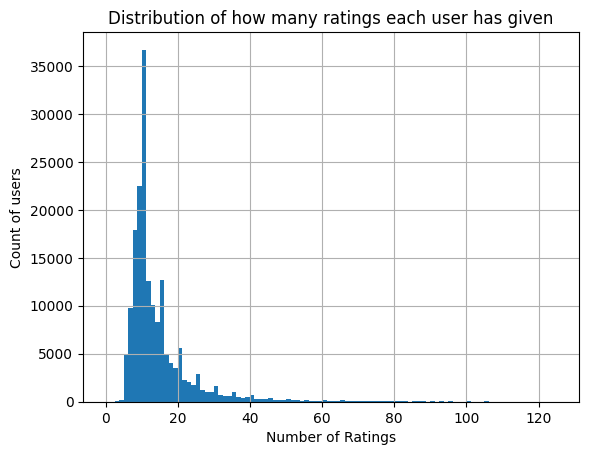

In [ ]:
train.steamid.value_counts().hist(bins=100, range=[0,125])
plt.title('Distribution of how many ratings each user has given')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of users')

There are no users who have played an unreasonable amount of games. -> no bots :)

But there are users who have reviewed very little games.

Text(0, 0.5, 'Count of games')

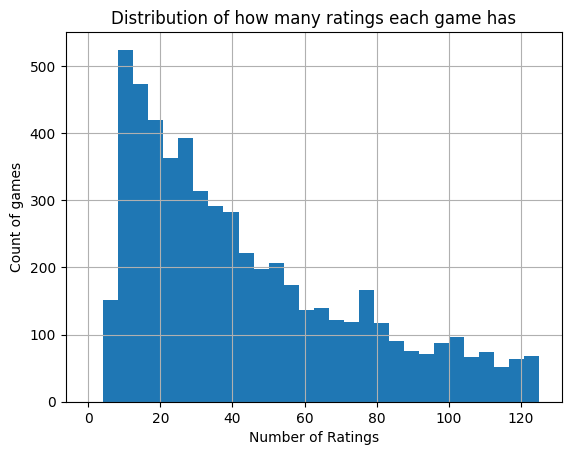

In [ ]:
train.appid.value_counts().hist(bins=30, range=[0,125])
plt.title('Distribution of how many ratings each game has')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of games')

There are also games that have been reviewed very little.

Since it's very difficult to make predictions on users or games that have very little data, we remove the gamers that have reviewd too little games, and the games that have received too little reviews.
We do this until we converge to a point where every user has reviewed at least 5 games, and every game has at least 5 reviews.


In [134]:
# Fixing the differnce in format of the ids in the two datasets
game_data = game_data.drop(2074) #column headers in data
game_data = game_data.reset_index(drop=True) # resetting the indexes
game_data = game_data[game_data['appid'].str.isnumeric()]
game_data['appid'] = game_data['appid'].astype('int64')
game_data = game_data[game_data['appid'] != 704230] #remove game that prevents game id tranformation in next block

In [135]:
# Encode the appid's and steamid's to be from 0 to n-1
user_enc = LabelEncoder()
train["steamid"] = user_enc.fit_transform(train["steamid"].values)

app_enc = LabelEncoder()
train["appid"] = app_enc.fit_transform(train["appid"].values)

test["steamid"] = user_enc.transform(test["steamid"].values)
test["appid"] = app_enc.transform(test["appid"].values)

game_data["appid"] = app_enc.transform(game_data["appid"].values)

## Train-Test Split

In [109]:
# Perform the split on the filtered data
# Only used for checking models, but to skip when making the final predictions to submit
train, eval = train_test_split(train, test_size=0.2, random_state=42, stratify=train['steamid'])

## Normalising the train data

In [ ]:
columns_to_scale = ["playtime_forever", "playtime_at_review", "num_games_owned", "num_reviews"]

# Extract columns to scale from the DataFrame
columns_scaled = train[columns_to_scale]

# Scale the extracted columns
scaler = MinMaxScaler()
scaled_columns = scaler.fit_transform(columns_scaled)

# Create a DataFrame with the scaled columns
train_scaled = pd.DataFrame(scaled_columns, columns=columns_to_scale)

# Replace the original columns with the scaled ones in the original DataFrame
train[columns_to_scale] = train_scaled

## Results table

Let's create a table to store the results of the models.

In [110]:
results = pd.DataFrame(columns=['Model', 'f0.5_score'])

def add_res(model_name, score):
    global results
    results = pd.concat([results, pd.DataFrame([[model_name, score]], columns=['Model', 'f0.5_score'])])
    display(results.sort_values(by=['f0.5_score']))

## Baselines Model


### User Average

The first baseline is the average rating of the user. If the user usually votes up, then it will vote up, if the user usually votes down, then it will vote down.
If the user has not rated any games, then we use the most common vote for that game among all other users.

In [122]:
# baseline model to do user average rating
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook

class UserAverageRating:
    def __init__(self):
        self.user_ratings = None
        self.default_rating = None

    def fit(self, X, y):
        # Calculate default rating
        global_zeros = np.sum(y==0)
        global_ones = np.sum(y==1)
        self.default_rating = 1 if global_ones >= global_zeros else 0

        # Calculate user total ratings and positive ratings
        user_counts = X.groupby('steamid')['voted_up'].count()
        user_positive_counts = X.groupby('steamid')['voted_up'].sum()

        # Avoid division by zero by adding a small epsilon
        epsilon = 1e-8

        # Calculate user rating
        user_ratios = (user_positive_counts + epsilon) / (user_counts + epsilon)
        self.user_ratings = user_ratios.apply(lambda x: 1 if x >= 0.5 else 0)

    def predict(self, X):
        print("Predicting...")
        y_pred = []
        for user_id in tqdm_notebook(X.steamid):
            if user_id in self.user_ratings:
                y_pred.append(self.user_ratings[user_id])
            else:
                y_pred.append(self.default_rating)

        return np.array(y_pred)


user_average_rating = UserAverageRating()
user_average_rating.fit(train, train.voted_up)

y_pred = user_average_rating.predict(eval)
fbeta = fbeta_score(eval.voted_up, y_pred, beta=0.5)
add_res('User Average Rating', fbeta)

In [123]:
# Making predicitons on the test data and saving them to a csv file
test_pred = user_average_rating.predict(test)

Predicting...


  0%|          | 0/657469 [00:00<?, ?it/s]

In [124]:
output_useravg = pd.DataFrame({'id': test['id'], 'voted_up': test_pred})
output_useravg.to_csv('useravg.csv', index = False)

### Game Average

The second baseline is the average rating of the game. It is 1 if the game has been more upvoted than downvoted, zero otherwise. If a game has not been rated by any user, then we use whether among all games there are more upvotes or downvotes and follow that.

In [125]:
class GameAverageRating:
    def __init__(self):
        self.game_ratings = None
        self.default_rating = None

    def fit(self, X, y):
        # Calculate default rating
        global_zeros = np.sum(y==0)
        global_ones = np.sum(y==1)
        self.default_rating = 1 if global_ones >= global_zeros else 0

        # Calculate games total ratings and positive ratings
        game_counts = X.groupby('appid')['voted_up'].count()
        game_positive_counts = X.groupby('appid')['voted_up'].sum()

        # Avoid division by zero by adding a small epsilon
        epsilon = 1e-8

        # Calculate user rating
        game_ratios = (game_positive_counts + epsilon) / (game_counts + epsilon)
        self.game_ratings = game_ratios.apply(lambda x: 1 if x >= 0.5 else 0)

    def predict(self, X):
        print("Predicting...")
        y_pred = []
        for game_id in tqdm_notebook(X.appid):
            if game_id in self.game_ratings:
                y_pred.append(self.game_ratings[game_id])
            else:
                y_pred.append(self.default_rating)

        return np.array(y_pred)

game_average_rating = GameAverageRating()
game_average_rating.fit(train, train.voted_up)

y_pred = game_average_rating.predict(eval)
fbeta = fbeta_score(eval.voted_up, y_pred, beta=0.5)
add_res('Game Average Rating', fbeta)

In [126]:
test_pred = game_average_rating.predict(test)

Predicting...


  0%|          | 0/657469 [00:00<?, ?it/s]

In [128]:
output_useravg = pd.DataFrame({'id': test['id'], 'voted_up': test_pred})
output_useravg.to_csv('game_avg.csv', index = False)

## Collaborative Filtering

### Alternating Least Squares

For collaborative we use matrix factorization with alternating least squares.

In [141]:
class MatrixFactorizationModel_ALS(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_dim):
        super(MatrixFactorizationModel_ALS, self).__init__()

        self.embedding_dim = embedding_dim

        self.user_emb = tf.keras.layers.Embedding(num_users, embedding_dim)
        self.item_emb = tf.keras.layers.Embedding(num_items, embedding_dim)

    def call(self, inputs):
        user_ids = inputs[:, 0]
        item_ids = inputs[:, 1]

        user_emb = self.user_emb(user_ids)
        item_emb = self.item_emb(item_ids)

        user_emb = tf.reshape(user_emb, [-1, self.embedding_dim])
        item_emb = tf.reshape(item_emb, [-1, self.embedding_dim])

        continuous_pred = tf.keras.layers.Dot(axes=1)([user_emb, item_emb])

        return continuous_pred

    def custom_fit(self, epochs, x, y):
        for epoch in range(epochs):
            print("Epoch {}/{} |".format(epoch+1, epochs), end="\t")
            self.user_emb.trainable = epoch % 2 == 0
            self.item_emb.trainable = epoch % 2 == 1

            self.fit(
                x = x,
                y = y,
                batch_size = 24000,
                epochs = 1,
                verbose = 1,
                shuffle = True
            )


In [137]:
num_users = train.steamid.nunique()
num_items = train.appid.nunique()
print(num_users)
print(num_items)

177721
8137


In [142]:
als_model = MatrixFactorizationModel_ALS(
    num_users = num_users,
    num_items = num_items,
    embedding_dim = 64)

# compile the model
als_model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [
        tf.keras.metrics.MeanAbsoluteError("MAE")
    ]
)

als_model.custom_fit(
    epochs = 1,
    x = train[["steamid", "appid"]].values,
    y = train["voted_up"].values
)

110/110 [==============================] - 30s 268ms/step - loss: 0.8270 - MAE: 0.8282


In [143]:
continuous_pred = als_model.predict(test[["steamid", "appid"]].values)
binary_pred = np.array([1 if score > 0.5 else 0 for score in continuous_pred])

20546/20546 [==============================] - 41s 2ms/step


In [ ]:
output_useravg = pd.DataFrame({'id': test['id'], 'voted_up': binary_pred})
output_useravg.to_csv('matrix_fact.csv', index = False)

In [ ]:
fbeta = fbeta_score(eval.voted_up, binary_pred, beta=0.5)
add_res('Matrix Factorization ALS', fbeta)

## Content-Based Filtering

For content-based filtering we will use the genres of the anime, and BERT embeddings of the synopsis. We will use the embedding to find the similarity between the animes. Then, we will use the similarity to find the rating of the anime.

We will use the following formula for the prediction:

$$
\hat{r}_{u,i} = \frac{\sum_{j \in N_i} s_{i,j} r_{u,j}}{\sum_{j \in N_i} s_{i,j}}
$$

where $N_i$ is the set of animes similar to anime $i$ and $s_{i,j}$ is the similarity between anime $i$ and anime $j$.

---

In the current implementation we will be using the following formula for the prediction. Not weighted by similarity.
$$
\hat{r}_{u,i} = \frac{\sum_{j \in N_i} r_{u,j}}{|N_i|}
$$

In [ ]:
# deleting the games that only appear in the game_data to match two tables
unique_game_data_appids = set(game_data['appid'].unique())
unique_train_appids = set(train['appid'].unique())
common_ids = unique_game_data_appids.intersection(unique_train_appids)
train = train[train['appid'].isin(common_ids)]

### Genres

In [ ]:
class GenresSimRating:
    def __init__(self):
        self.user_emb = {}
        self.user_mean = None
        self.appid_mean = None
        self.default_rating = None

    def fit(self, X, y):
        print("Calculating user embeddings...")
        # Calculate default rating
        global_zeros = np.sum(y==0)
        global_ones = np.sum(y==1)
        self.default_rating = 1 if global_ones >= global_zeros else 0

        self.user_mean = X.groupby('steamid')['voted_up'].mean()
        self.appid_mean = X.groupby('appid')['voted_up'].mean()
        for user_id, group in tqdm_notebook(X.groupby('steamid')):
            selection = game_data.appid.isin(group.appid)
            if selection.sum() == 0:
                continue
            emb = game_data[selection].filter(regex='Genre').mean() # for genres
            self.user_emb[user_id] = emb / np.linalg.norm(emb)

        #print(self.user_emb)
        #print(self.user_mean)
    def predict(self, X):
        print("Predicting...")
        y_pred = []
        count = 0

        for user_id, game_id in tqdm_notebook(zip(X.steamid, X.appid), total=X.shape[0]):
            if user_id in self.user_emb and game_id in game_data.appid:
                user_emb = self.user_emb[user_id]
                game_emb = game_data.loc[game_id, game_data.filter(regex='Genre').columns]
                cos_sim = np.dot(user_emb, game_emb) / np.linalg.norm(game_emb)
                y_pred.append(cos_sim)
            else:
                y_pred.append(self.user_mean.get(user_id, self.appid_mean.get(game_id, self.default_rating))) # if there is an unseen value get the avg vote for that game if cant get that either get random int
                count = count +1
        y_pred_binary = np.array([1 if score > 0.5 else 0 for score in y_pred])
        print(f"used the fallback {count} times")
        print(f"n of actually handled {len(X) - count}")
        print(f"% of data predicted on genres{count/len(X)}")

        return y_pred_binary
    def get_appid_avg(self, X, steamid):
        print

genre_sim_rating = GenresSimRating()


In [ ]:
genre_sim_rating.fit(train, train.voted_up)

Calculating user embeddings...


  0%|          | 0/176241 [00:00<?, ?it/s]

In [ ]:
y_pred = genre_sim_rating.predict(eval)


Predicting...


  0%|          | 0/357102 [00:00<?, ?it/s]

used the fallback 118095 times
n of actually handled 239007
% of data predicted on genres0.3307038325184401


In [ ]:
fbeta = fbeta_score(eval.voted_up, y_pred, beta=0.5)
mae = mean_absolute_error(eval.voted_up, y_pred)
print(mae)
print(fbeta)
add_res('Genre Similarity Rating', fbeta)

0.35520663563911714
0.815523557645215


,Model,f0.5_score
0,Genre Similarity Rating,0.668258
0,Genre Similarity Rating,0.815524
0,Genre Similarity Rating,0.815524
0,Genre Similarity Rating,0.815524


In [ ]:
# Making predicitons on the test data and saving them to a csv file
test_pred = genre_sim_rating.predict(test)
output_genre_sim = pd.DataFrame({'id': test['id'], 'voted_up': test_pred})
output_genre_sim.to_csv('genre_category.csv', index = False)

Predicting...


  0%|          | 0/657469 [00:00<?, ?it/s]

used the fallback 227185 times
n of actually handled 430284


### BERT Embeddings

BERT is a language model that can be used to get embeddings of text. We will use it to get embeddings of the synopsis of the anime. Then, we will use the embeddings to find the similarity between the animes. We will use the cosine similarity.

We can check the similarity of semantic meaning from the reviews that people have left

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

def bert_embed_parallel(texts, batch_size=32):
    # Load pre-trained model tokenizer (vocabulary)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Load pre-trained model
    model = BertModel.from_pretrained('bert-base-uncased')

    # Process texts in batches
    all_embeddings = []
    for i in tqdm_notebook(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        # Tokenize and pad the batch
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")

        # Get embeddings with no gradient computation
        with torch.no_grad():
            outputs = model(**inputs)

        # Compute the mean of the last hidden states for each input in the batch
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
        all_embeddings.extend(embeddings)

    return np.array(all_embeddings)

In [ ]:
# Example usage
texts = list(anime.synopsis.values)
embedded_texts = bert_embed_parallel(texts)

# save the embeddings
np.save('bert_embeddings.npy', embedded_texts)

We will make a similar model as with the genres, but instead of using the genres, we will use the embeddings.

In [ ]:
# ––
# THIS IS MOST INEFFICIENT WAY TO DO THIS
# THINK MAYBE HOW TO PARALLELIZE THIS
# BY CHANGING THE FOR LOOP TO LINEAR ALGEBRA
# ––

class BertSimRating:
    def __init__(self):
        self.user_emb = {}
        self.user_mean = None

    def fit(self, X, y):
        print("Calculating user embeddings...")
        self.user_mean = X.groupby('user_enc_id')['rating'].mean()

        for user_id, group in tqdm_notebook(X.groupby('user_enc_id')):
            selection = anime.anime_id.isin(group.anime_id)
            if selection.sum() == 0:
                continue
            emb = embedded_texts[selection].mean(axis=0)
            self.user_emb[user_id] = emb / np.linalg.norm(emb)

    def predict(self, X):
        print("Predicting...")
        y_pred = []

        for user_id, anime_id in tqdm_notebook(zip(X.user_enc_id, X.anime_enc_id), total=X.shape[0]):
            if user_id in self.user_emb and anime_id in anime.index:
                user_emb = self.user_emb[user_id]
                anime_emb = embedded_texts[anime_id]
                cos_sim = np.dot(user_emb, anime_emb) / np.linalg.norm(anime_emb)
                y_pred.append(cos_sim)
            else:
                y_pred.append(self.user_mean[user_id])

        return np.array(y_pred)

In [ ]:
bert_sim_rating = BertSimRating()
bert_sim_rating.fit(train_ratings, train_ratings.rating)

y_pred = bert_sim_rating.predict(test_ratings)

mae = mean_absolute_error(test_ratings.rating, y_pred)

add_res('BERT Similiraty Rating', mae)

## Hybrid Model

A good explanation on how to do ensamble here: https://www.quora.com/How-can-I-combine-recommender-system-outputs-user-item-matrix-via-an-ensemble